## Initial setup

In [ ]:
import pandas as pd
import numpy as np
from chardet import detect
import matplotlib.pyplot as plt
import seaborn as sns
import os
import importlib.util
import subprocess

In [2]:
# Defining default visualisation settings
sns.set_theme(palette='inferno')
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
#Configuring LLM for later result interpretations
if 'OPENAI_API_KEY' in os.environ:
    api_key = os.environ['OPENAI_API_KEY']
    from openai import OpenAI
    model,role = "gpt-3.5-turbo","user"
    client = OpenAI(api_key = api_key)
else:
    api_key = None

### Preparing the data

In [4]:
def check_encoding(file: str = None)-> str:
    with open(file, 'rb') as f:
        encoding = detect(f.read(10000))['encoding']
        return encoding

def load_apartments_data(source:str):
    """
    Checks if the file 'apartment_data.csv' exists in the current working directory.
    If not, fetches data using ucimlrepo, saves it as a CSV file, and loads it into a DataFrame.
    Returns a DataFrame `apartments_source`.
    """
    file_name = "apartment_data.csv"

    # Check if the ucimlrepo package is installed
    if importlib.util.find_spec("ucimlrepo") is None:
        print("The 'ucimlrepo' package is not installed. Installing it now...")
        subprocess.check_call(["pip", "install", "ucimlrepo"])
        print("Installation complete.")

    if not os.path.exists(file_name):
        print(f"The file '{file_name}' does not exist. Fetching data...")
        # Install ucimlrepo (requires an internet connection)
        try:
            import ucimlrepo
        except ImportError:
            os.system("pip install ucimlrepo")
            from ucimlrepo import fetch_ucirepo
        # Fetching data from the UC Irvine repository
        from ucimlrepo import fetch_ucirepo
        apartment_for_rent_classified = fetch_ucirepo(id=555)

        # Preparing the data
        X = apartment_for_rent_classified.data.features
        y = apartment_for_rent_classified.data.targets

        # Combining features and targets into one DataFrame
        apartments_source = pd.concat([X, y], axis=1)

        # Saving to CSV
        apartments_source.to_csv(file_name, index=False)
        print(f"Data has been fetched and saved to the file '{file_name}'.")
    else:
        print(f"The file '{file_name}' already exists. Loading data...")

    # Loading data into a DataFrame
    apartments_source = pd.read_csv(source, encoding=check_encoding(source),low_memory=False,
                                    encoding_errors = 'ignore',
                                    delimiter=',')
    return apartments_source

apartments_source = load_apartments_data("apartment_data.csv")


The file 'apartment_data.csv' already exists. Loading data...


In [5]:
#Leaving original data aside
apartments = apartments_source.copy()

## Data exploration

In [6]:
#Exploring basic properties of the dataframe
def describe_df(df: pd.DataFrame)-> None:
    """
    Given a dataframe, the function calls some most popular data exploration functions at once.
    :param df: 
    :return: None 
    """
    describe_functions = [(lambda df: df.head(5), "Head(5):"),
        (pd.DataFrame.describe, "Describe:"),
        (pd.DataFrame.info, "Info:"),
        (lambda df: df.isnull().sum()[df.isnull().sum() > 0],"Null values:")]
    
    for func,name in describe_functions:
        print(f"\n Applying function: {name}",end = "\n")
        print(func(df))
        
describe_df(apartments)


 Applying function: Head(5):
                 category                            title  \
0  housing/rent/apartment       One BR 507 & 509 Esplanade   
1  housing/rent/apartment      Three BR 146 Lochview Drive   
2  housing/rent/apartment  Three BR 3101 Morningside Drive   
3  housing/rent/apartment            Two BR 209 Aegean Way   
4  housing/rent/apartment         One BR 4805 Marquette NE   

                                                body amenities bathrooms  \
0  This unit is located at 507 & 509 Esplanade, R...       NaN         1   
1  This unit is located at 146 Lochview Drive, Ne...       NaN       1.5   
2  This unit is located at 3101 Morningside Drive...       NaN         2   
3  This unit is located at 209 Aegean Way, Vacavi...       NaN         1   
4  This unit is located at 4805 Marquette NE, Alb...       NaN         1   

  bedrooms currency fee  has_photo pets_allowed  ...  price_display  \
0        1      USD  No  Thumbnail         Cats  ...           2195  

In [7]:
#Removing unnecessary columns
apartments.drop(columns=['category','title','body','has_photo','source','time','price_display','currency','cityname','price_type'], inplace=True)
#Proper formatting of the columns
apartments.columns = apartments.columns.str.capitalize()
#Dropping duplicates
apartments.drop_duplicates(inplace=True)

In [8]:
#Converting numerical columns to float from objects
apartments[apartments['Bathrooms']=='No'] = np.nan
apartments[apartments['Bathrooms']=='Thumbnail'] = np.nan
apartments = apartments.astype({'Bathrooms':float,"Bedrooms":float,"Square_feet":float})
apartments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91055 entries, 0 to 99825
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Amenities     75958 non-null  object 
 1   Bathrooms     90989 non-null  float64
 2   Bedrooms      90935 non-null  float64
 3   Fee           91051 non-null  object 
 4   Pets_allowed  36065 non-null  object 
 5   Price         91050 non-null  float64
 6   Square_feet   91051 non-null  float64
 7   Address       7940 non-null   object 
 8   State         90784 non-null  object 
 9   Latitude      91026 non-null  float64
 10  Longitude     91026 non-null  float64
dtypes: float64(6), object(5)
memory usage: 8.3+ MB


In [9]:
#Handling nulls: there are lots of empty values for pets and amenities, so I leave them in the model, but only small amount of other missing values, so I drop the other features
apartments['Pets_allowed'] = apartments['Pets_allowed'].fillna('Unknown')
apartments['Amenities'] = apartments['Amenities'].fillna('None')
apartments.dropna(subset=['Bathrooms','Bedrooms','Price','Latitude','Longitude','State'],inplace=True)
apartments.drop('Address',axis=1,inplace=True)

In [10]:
#% of records left from the original df
print(f' % of the data set left after dropping nulls: {(apartments.shape[0]/apartments_source.shape[0]).__format__(".2f")}'
)

 % of the data set left after dropping nulls: 0.91


##### Removing 'state' and replacing it with 'population' to easier handle the categorical values. Getting the population data and state full names from onlines sources.

In [11]:
#Loading a table containing US division into regions
US_states_source = "US_states.csv"
US_states = pd.read_csv(US_states_source,encoding=check_encoding(US_states_source),delimiter=";")
US_states.loc[US_states['State'] == 'Washington, D.C.', 'State'] = 'District of Columbia'

In [12]:
# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population" #data of US population by states
url2 = "https://www.bu.edu/brand/guidelines/editorial-style/us-state-abbreviations/" #table of the states' abbreviatons
# Extract all tables from the page
tables = pd.read_html(url)
# Reading the table containing population data for each state
state_population = tables[0]
state_population = state_population[[('State or territory','State or territory'),('Census population[8][9][a]','July 1, 2024 (est.)')]]
state_population.columns = state_population.columns.get_level_values(1) #the table is a multindex one, reading only column values from level 1
state_population.rename(columns = {'July 1, 2024 (est.)':'Population','State or territory':'State'},inplace=True)
#Creating table with US states full names and abbreviations
abbr_table = pd.read_html(url2,header=0)[0]
abbr_table.rename(columns = {'Full Name':'State',"2-letter USPS":"Code"},inplace=True)

C:\Users\Michau\AppData\Local\Temp\ipykernel_28360\356461454.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_population.rename(columns = {'July 1, 2024 (est.)':'Population','State or territory':'State'},inplace=True)


In [13]:
#Finally merging the tables to gain data of population in the original table
state_population = state_population.merge(abbr_table,on = 'State',how = 'left').merge(US_states,on = "State", how = 'left' )
state_population.dropna(subset = 'Code', inplace = True)
state_population.drop(columns = 'Traditional Abbreviation',inplace = True)
apartments = apartments.merge(state_population,left_on = 'State',right_on = 'Code',how = 'left')
apartments.drop(columns = ['State_x','Code'],inplace = True)

In [14]:
apartments.head(3)

Amenities  Bathrooms  Bedrooms Fee Pets_allowed   Price  Square_feet  \
0      None        1.0       1.0  No         Cats  2195.0        542.0   
1      None        1.5       3.0  No    Cats,Dogs  1250.0       1500.0   
2      None        2.0       3.0  No      Unknown  1395.0       1650.0   

   Latitude  Longitude         State_y  Population        Division Region  
0   33.8520  -118.3759      California  39431263.0         Pacific   West  
1   37.0867   -76.4941        Virginia   8811195.0  South Atlantic  South  
2   35.8230   -78.6438  North Carolina  11046024.0  South Atlantic  South

In [15]:
import plotly.express as px

fig = px.treemap(
    apartments.assign(LogPopulation=np.log(apartments['Population'])),
    path=['Region', 'Division', 'State_y'],  # hierarchy
    values='LogPopulation',  # base for size of the rectangles
    color='Population',
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        'Region': 'Region',
        'Division': 'Division',
        'State_y': 'State',
        'Population': 'Population'
    },
    title="Interactive treemap of US division, sizes based on the population counts of each state"
)
fig.update_layout(
    width=1300,
    height=600)
fig.update_layout(
    showlegend=False,
    annotations=[
        dict(
            x=0.01,
            y=-0.05,
            text="Division adopted after US Census Bureau",
            showarrow=False,
            font=dict(size=10, color="white"),
            align="left")])
fig.show()

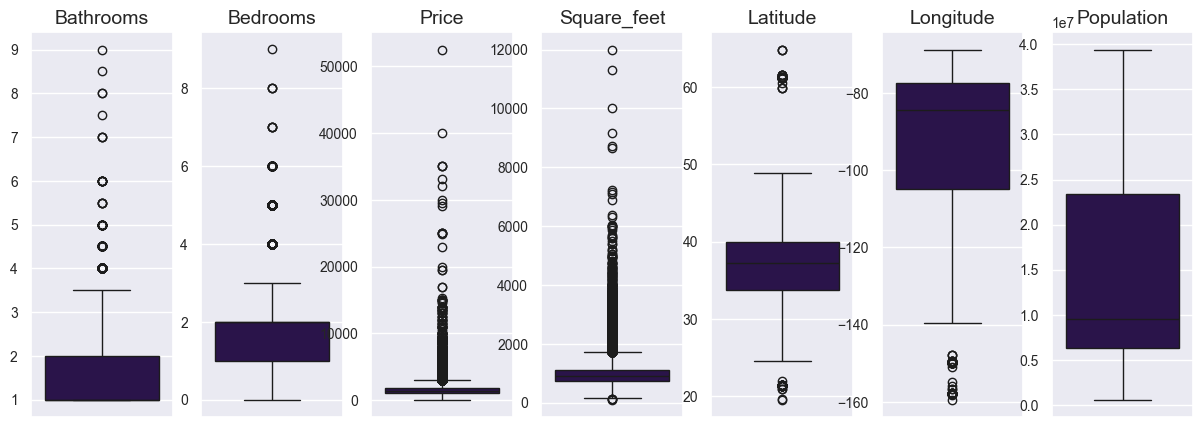

In [16]:
# Box plots of all the features
num_apartments = apartments.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=1, ncols=len(num_apartments.columns), figsize=(15, 5), sharey=False)

for i, column in enumerate(num_apartments.columns):
    sns.boxplot(data=num_apartments, y=column, ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_ylabel("") 
plt.show()

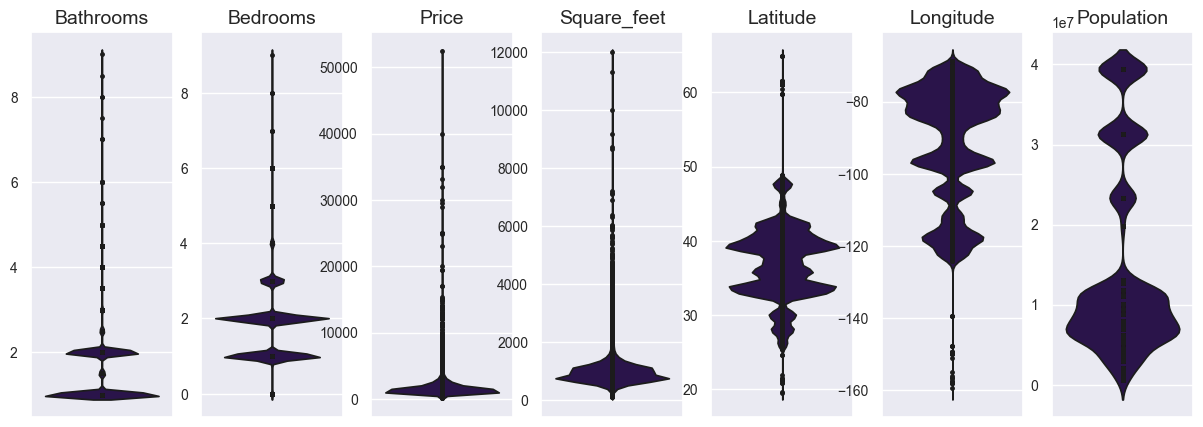

In [17]:
# Violin plots
num_apartments = apartments.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=1, ncols=len(num_apartments.columns), figsize=(15, 5), sharey=False)
for i, column in enumerate(num_apartments.columns):
    sns.violinplot(data=num_apartments, y=column, ax=axes[i], inner="point")
    axes[i].set_title(column)
    axes[i].set_ylabel("")
plt.show()

In [18]:
#Checking the proportions of values in Bedrooms and States
bedrooms_ratios = apartments['Bedrooms'].value_counts()/apartments.shape[0]*100
bedrooms_ratios.sort_index(inplace=True,ascending=True)
states_ratios = apartments['State_y'].value_counts()/apartments.shape[0]*100
regions_ratios = apartments['Region'].value_counts()/apartments.shape[0]*100
print(regions_ratios)

Region
South        43.108928
West         25.898907
Northeast    18.518927
Midwest      12.473237
Name: count, dtype: float64


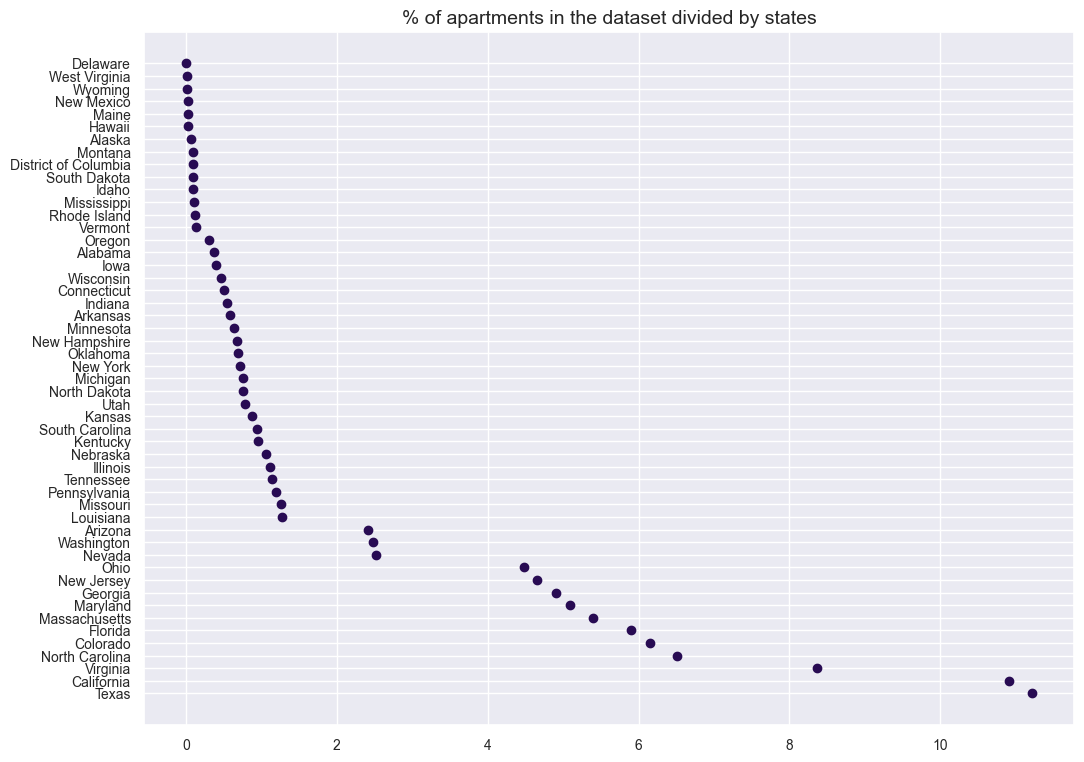

In [19]:
#Visualising
plt.figure(figsize=(12,9))
plt.scatter(states_ratios,
    states_ratios.index)
plt.title('% of apartments in the dataset divided by states')
plt.show()
    

<Axes: title={'center': '% of apartments divided by number of bedrooms'}, xlabel='Bedrooms'>

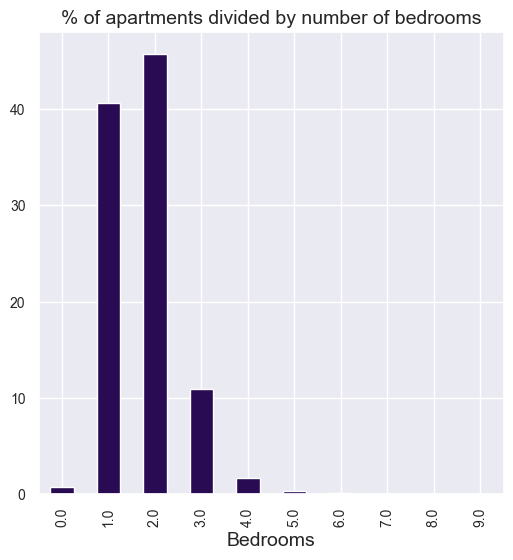

In [20]:
bedrooms_ratios.plot(kind='bar', stacked=False, figsize=(6, 6),title="% of apartments by number of bedrooms")


Text(0, 0.5, '')

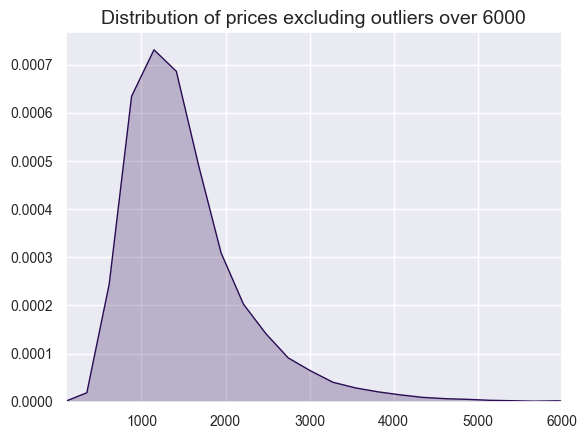

In [21]:
#Checking the distribution of prices in the dataset
plot = sns.kdeplot(data = apartments,
            x = 'Price',fill=True)
plot.set(xlim=(min(apartments['Price']),6000))
plot.set_title("Distribution of prices excluding outliers over 6000")
plot.set_xlabel("")
plot.set_ylabel("")

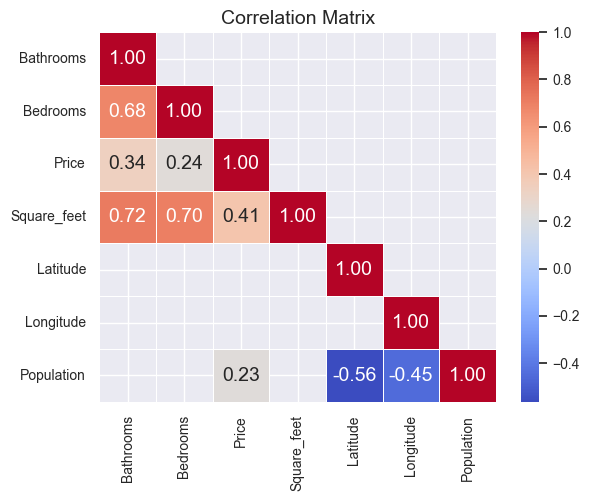

In [25]:
#Creating a correlation matrix, removing double entries to receive a lower triangular matrix
from pandas.plotting import scatter_matrix
correlation_matrix = apartments.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))
masked_correlation_matrix = correlation_matrix.mask(mask).where(abs(correlation_matrix) > 0.2) #setting a limit so to not display irrelevant correlations
np.fill_diagonal(masked_correlation_matrix.values, 1)
sns.heatmap(masked_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


array([[<Axes: xlabel='Price', ylabel='Price'>,
        <Axes: xlabel='Square_feet', ylabel='Price'>,
        <Axes: xlabel='Population', ylabel='Price'>],
       [<Axes: xlabel='Price', ylabel='Square_feet'>,
        <Axes: xlabel='Square_feet', ylabel='Square_feet'>,
        <Axes: xlabel='Population', ylabel='Square_feet'>],
       [<Axes: xlabel='Price', ylabel='Population'>,
        <Axes: xlabel='Square_feet', ylabel='Population'>,
        <Axes: xlabel='Population', ylabel='Population'>]], dtype=object)

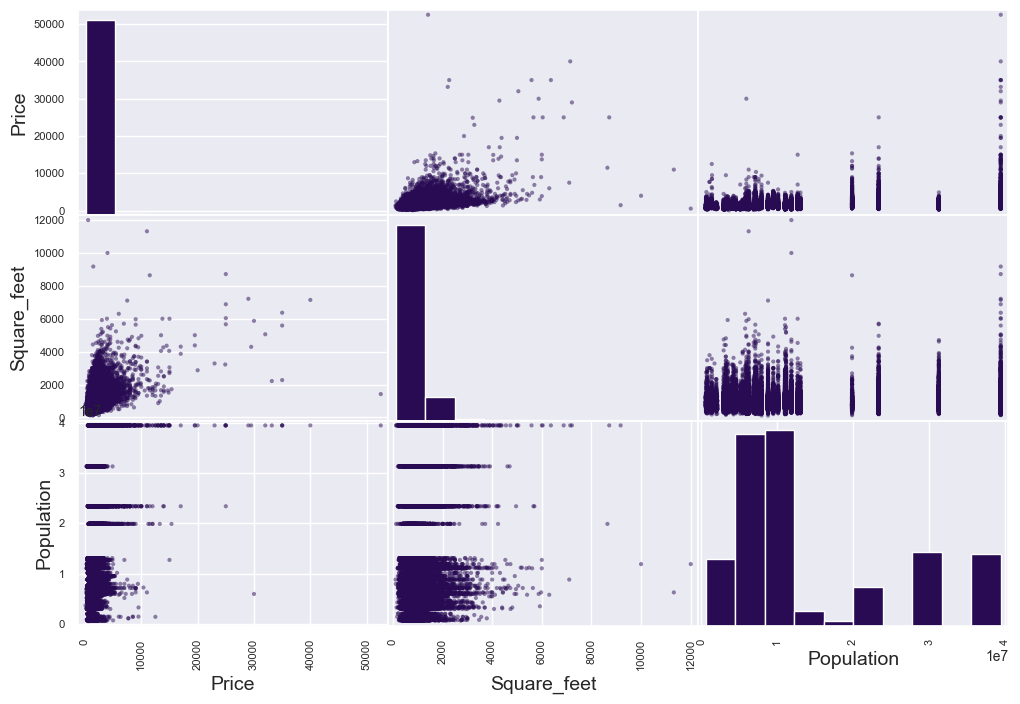

In [26]:
scatter_matrix(apartments[['Price','Square_feet','Population']],figsize=(12,8))

### Preparing data for machine learning

#### Data cleaning

In [27]:
#Confirming the amount of null values is 0
assert apartments.isnull().sum().sum() == 0, "There are some missing values in the dataframe."

#### Handling text and categorical data

In [28]:
# Extracting all values from Amenities column and making separate 1/0 columns for each amenity separately
all_amenities = set()
apartments['Amenities'].dropna().apply(lambda x: all_amenities.update(x.split(',')))
#apartments_test['Amenities'].dropna().apply(lambda x: all_amenities.update(x.split(',')))
for amenity in all_amenities:
    apartments[amenity] = apartments['Amenities'].apply(lambda x: 1 if amenity in x.split(',') else 0)

In [29]:
# Separating data on pets to 1/0 encoding
all_pets = set()
apartments['Pets_allowed'].dropna().apply(lambda x: all_pets.update(x.split(',')))
for pet in all_pets:
    apartments[pet] = apartments['Pets_allowed'].apply(lambda x: 1 if pet in x.split(',') else 0)


In [30]:
#Dropping unnecessary columns and renaming some new ones for clarity
apartments.drop(columns = ['Pets_allowed','Amenities','State_y','Unknown'],inplace=True)
apartments.rename({"None":"No amenities","Dogs":"Dogs_allowed","Cats":"Cats_allowed"}, axis=1, inplace=True)


In [31]:
# Transforming Fee from yes/no to 1/0
apartments['Fee'] = apartments['Fee'].map({"Yes":1, "No":0})


In [32]:
#One hot encoding for States and regions
apartments_cat = apartments.select_dtypes(object)
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
apartments_cat_1hot = cat_encoder.fit_transform(apartments_cat)
#converting results to a dataframe
apartments_cat_1hot_df = pd.DataFrame(apartments_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out(apartments_cat.columns))
# adding to the original data frame
apartments = pd.concat([apartments, apartments_cat_1hot_df], axis=1)

In [33]:
apartments.drop(columns=['Region','Division'],inplace = True)

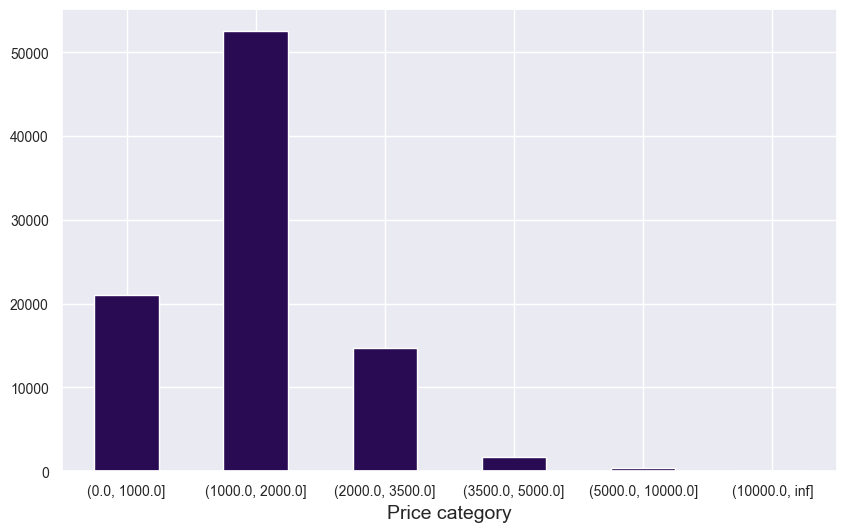

In [34]:
#Grouping size categories so the division can be used to take the stratified sample
bins = [0,1000,2000,3500,5000,10000,np.inf]
apartments['Price category'] = pd.cut(apartments['Price'],
                                      bins = bins
                                      )
apartments["Price category"].value_counts().sort_index().plot.bar(rot = 0, grid=True,figsize=(10,6))
plt.xlabel("Price category")
plt.show()

In [35]:
apartments.head(1)

Bathrooms  Bedrooms  Fee   Price  Square_feet  Latitude  Longitude  \
0        1.0       1.0    0  2195.0        542.0    33.852  -118.3759   

   Population  Internet Access  No amenities  ...  Division_New England  \
0  39431263.0                0             0  ...                   0.0   

   Division_Pacific  Division_South Atlantic  Division_West North Central  \
0               1.0                      0.0                          0.0   

   Division_West South Central  Region_Midwest  Region_Northeast  \
0                          0.0             0.0               0.0   

   Region_South  Region_West    Price category  
0           0.0          1.0  (2000.0, 3500.0]  

[1 rows x 52 columns]

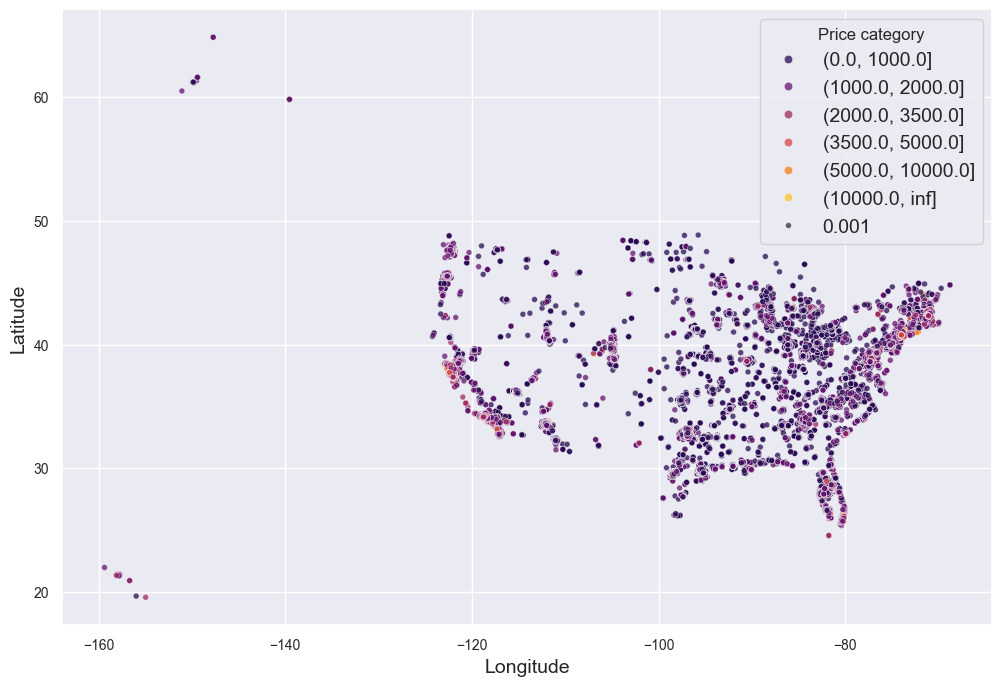

In [36]:
# plotting a scatter plot to check if there is any visible relation between localisation and the houses' size 
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='Longitude',
    y='Latitude',
    hue='Price category',
    data=apartments,
    alpha=0.75,
    size=0.001,
    legend = 'brief',
palette='inferno')


#### Feature scaling

#### Normalisation

In [37]:
apartments_to_normalize = apartments.drop(columns=['Price','Price category'])

In [38]:
apartments_to_normalize.head()

Bathrooms  Bedrooms  Fee  Square_feet  Latitude  Longitude  Population  \
0        1.0       1.0    0        542.0   33.8520  -118.3759  39431263.0   
1        1.5       3.0    0       1500.0   37.0867   -76.4941   8811195.0   
2        2.0       3.0    0       1650.0   35.8230   -78.6438  11046024.0   
3        1.0       2.0    0        820.0   38.3622  -121.9712  39431263.0   
4        1.0       1.0    0        624.0   35.1038  -106.6110   2130256.0   

   Internet Access  No amenities  Parking  ...  Division_Mountain  \
0                0             0        0  ...                0.0   
1                0             0        0  ...                0.0   
2                0             0        0  ...                0.0   
3                0             0        0  ...                0.0   
4                0             0        0  ...                1.0   

   Division_New England  Division_Pacific  Division_South Atlantic  \
0                   0.0               1.0                      0.0   
1                   0.0               0.0                      1.0   
2                   0.0               0.0                      1.0   
3                   0.0               1.0                      0.0   
4                   0.0               0.0                      0.0   

   Division_West North Central  Division_West South Central  Region_Midwest  \
0                          0.0                          0.0             0.0   
1                          0.0                          0.0             0.0   
2                          0.0                          0.0             0.0   
3                          0.0                          0.0             0.0   
4                          0.0                          0.0             0.0   

   Region_Northeast  Region_South  Region_West  
0               0.0           0.0          1.0  
1               0.0           1.0          0.0  
2               0.0           1.0          0.0  
3               0.0           0.0          1.0  
4               0.0           0.0          1.0  

[5 rows x 50 columns]

In [39]:
#In case transformation does not require any training, sklearn can be used to transform a feature like in the example
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log,inverse_func=np.exp)
log_population = log_transformer.transform(apartments_to_normalize[['Population']])

In [40]:
from sklearn.preprocessing import StandardScaler
apartments_num = apartments_to_normalize.select_dtypes(include='number')
#when scaling sparse matrix without transforming  into dense one, subtracting mean during the standardization might be skipped, because otherwise it would thwart the matrix's sparsity
#Here I choose mixed approach to standardization, meaning treating separately sparse and dense part of the matrix
dense_columns,sparse_columns = (apartments_num.columns[apartments_num.nunique() > 2],
    apartments_num.columns[apartments_num.nunique() == 2])
apartments_num_std_scaled = apartments_num.copy()
sparse_scaler = StandardScaler(with_mean=False)
apartments_num_std_scaled[sparse_columns] = sparse_scaler.fit_transform(apartments_num[sparse_columns])

dense_scaler = StandardScaler(with_mean=True)
apartments_num_std_scaled[dense_columns] = dense_scaler.fit_transform(apartments_num[dense_columns])

In [41]:
apartments_num_std_scaled[['Price','Price category']] = apartments[['Price','Price category']]

## Create a Test Set

#### Stratified shuffle split

In [42]:
# Splitting the data to train and test
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(
    apartments_num_std_scaled,test_size=0.2,random_state=42,stratify = apartments['Price category']
)
#Comparison of % of values in original dataset and the stratified sample
(train_set['Price category'].value_counts()/len(train_set),
 apartments['Price category'].value_counts()/len(apartments))

(Price category
 (1000.0, 2000.0]     0.579696
 (0.0, 1000.0]        0.232728
 (2000.0, 3500.0]     0.163020
 (3500.0, 5000.0]     0.019327
 (5000.0, 10000.0]    0.004442
 (10000.0, inf]       0.000786
 Name: count, dtype: float64,
 Price category
 (1000.0, 2000.0]     0.579693
 (0.0, 1000.0]        0.232734
 (2000.0, 3500.0]     0.163017
 (3500.0, 5000.0]     0.019325
 (5000.0, 10000.0]    0.004448
 (10000.0, inf]       0.000784
 Name: count, dtype: float64)

In [43]:
#Dropping price category as it won't be useful anymore
train_set_labels = train_set['Price'].copy()
test_set_labels = test_set['Price'].copy()
train_set.drop(columns = ["Price category","Price"],inplace = True)
test_set.drop(columns = ["Price category","Price"],inplace = True)

#### Training and validating the model

In [44]:
#Testing if all values in the train set are numerical
assert all(train_set.dtypes.apply(lambda x: x.kind in 'iuf')), "There are still some features that are not numerical"

#####  1.Linear regression

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
lin_reg = LinearRegression()
lin_reg.fit(train_set, train_set_labels)
apartments_predictions_lr = lin_reg.predict(train_set)
lin_rmse = root_mean_squared_error(train_set_labels, apartments_predictions_lr)
interquartile_range = np.percentile(train_set_labels,75)-np.percentile(train_set_labels,25)
print(f"RMSE of linear regression model: {lin_rmse}, for the dataset of: \n{train_set_labels.describe()}")

RMSE of linear regression model: 668.277503914697, for the dataset of: 
count    72488.000000
mean      1550.862418
std        899.919476
min        100.000000
25%       1030.000000
50%       1375.000000
75%       1821.000000
max      52500.000000
Name: Price, dtype: float64


In [50]:
if api_key is not None:
    interpretation_lr = client.chat.completions.create(model = model,messages = [
        {"role":role,
         "content" : f"Interpret the results of the model: {lin_reg},RMSE: {lin_rmse}, for the dataset of: \n{train_set_labels.describe()}"}]
                                                    )
    print(interpretation_lr.choices[0].message.content)

The linear regression model resulted in a Root Mean Squared Error (RMSE) of 668.2775, which means that on average, the model's predictions were off by approximately $668.27 from the actual prices in the dataset.

The dataset contains prices of products, with a mean price of $1550.86 and a standard deviation of $899.92. The prices range from a minimum of $100 to a maximum of $52500, with most prices falling between $1030 (25th percentile) and $1821 (75th percentile).

Based on the RMSE value and the statistics of the dataset, it appears that the linear regression model may not be accurately capturing the variability and patterns in the data. The relatively high RMSE suggests that the model's predictions have a significant amount of error. This could be due to the presence of outliers or non-linear relationships in the data that are not being properly captured by the linear regression model. Further analysis and potentially trying a different model may be necessary to improve the predict

In [51]:
# Showing directly some predictions compared to labels
pd.DataFrame({"Predictions":apartments_predictions_lr[:5].round(2),"Labels": train_set_labels[:5].round(2)})

Predictions  Labels
75124      1152.40   967.0
67562      1278.92  1350.0
81939      1682.59  2230.0
46690      2489.05  2345.0
4545        376.45   400.0

##### 2. Decision Tree Regressor

In [52]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_set, train_set_labels)

DecisionTreeRegressor(random_state=42)

In [54]:
apartments_predictions_dt = tree_reg.predict(train_set)
dt_rmse = root_mean_squared_error(train_set_labels, apartments_predictions_dt)
print(f'Decision tree RMSE: {dt_rmse}')

Decision tree RMSE: 36.52052539968349


In [55]:
# Using cross validation to assess the decision tree model more precisely as the result of 36,5 is suspicious and it might have been overfitted.

#The cross validation function in sklearn expects utility function instead of the cost function, so "-" has to be added to receive RMSE scores in this case
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(
    tree_reg,train_set,train_set_labels,scoring = "neg_root_mean_squared_error", cv = 10
)
pd.Series(tree_rmses).describe()
print(
    f"model: {tree_reg},\nRMSE: {dt_rmse}, \nCross validation results: {tree_rmses}."
)

model: DecisionTreeRegressor(random_state=42),
RMSE: 36.52052539968349, 
Cross validation results: [571.68419238 533.14685297 502.46948674 449.75541138 462.60243917
 512.7426676  526.50429609 763.61232804 650.83411845 476.6788315 ].


In [56]:
if api_key is not None:
    interpretation_dt = client.chat.completions.create(model = model,messages = [
        {"role":role,
         "content" : f" model: {tree_reg},RMSE: {dt_rmse}, Cross validation results: {tree_rmses}. Interpret the results  for the dataset of: \n{train_set_labels.describe()}"}]
                                                    )
    print(interpretation_dt.choices[0].message.content)

The DecisionTreeRegressor model with a random state of 42 has a Root Mean Squared Error (RMSE) of 36.52. This means that on average, the model's predictions are off by approximately $36.52 from the actual Price values in the dataset.

The cross-validation results further demonstrate the model's performance. The results fluctuate between approximately 449.76 and 763.61, indicating some variability in the model's predictive accuracy across different folds of the dataset.

Looking at the descriptive statistics of the Price variable in the dataset, we can see that the mean Price is $1550.86, with a standard deviation of $899.92. The prices range from $100 to $52500, with the majority falling between $1030 and $1821 (25th to 75th percentiles).

Overall, the model's RMSE and cross-validation results suggest that it is capturing the variability in the Price values to some extent. However, there is room for improvement in terms of reducing prediction errors and increasing the model's accuracy.

#### 3. Random forest regressor

In [57]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state =42)
forest_rmses = -cross_val_score(forest_reg,train_set,train_set_labels,scoring = "neg_root_mean_squared_error", cv = 10)
pd.Series(forest_rmses).describe()

count     10.000000
mean     415.246785
std      109.585788
min      333.125316
25%      360.898497
50%      369.850346
75%      428.491625
max      688.553260
dtype: float64

In [58]:
if api_key is not None:
    interpretation_rf = client.chat.completions.create(model = model,messages = [
    {"role":role,
     "content" : f" model: {forest_reg},RMSE: {forest_rmses}, Cross validation results: {pd.Series(forest_rmses).describe()}. Interpret the results  for the dataset of: \n{train_set_labels.describe()}"}])
    print(interpretation_rf.choices[0].message.content)


The Random Forest Regressor model with a random state of 42 has an average Root Mean Squared Error (RMSE) of 415.25 for the dataset of prices. This means that on average, the model's predictions are off by around $415. The cross-validation results indicate that the model's performance is relatively consistent, with a standard deviation of 109.59.

Comparing this to the dataset of prices, we can see that the average price is $1550.86 with a standard deviation of $899.92. The model's RMSE of $415.25 is about 26.7% of the average price, indicating that the model's performance is relatively good considering the range of prices in the dataset. The model is able to predict prices with reasonable accuracy given the variability in the dataset.


#### Tuning the model (going with model 3) - with random search method

In [59]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
param_dist = {
    'n_estimators': np.arange(50, 301, 50),  # number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # features taken into consideration
    'max_depth': [None, 10, 20, 30, 40, 50],  # max trees depth
    'min_samples_split': [2, 5, 10],  # min samples to take
    'min_samples_leaf': [1, 2, 4],  # min samples in the leaves
    'bootstrap': [True, False]
}

forest_reg = RandomForestRegressor(random_state=42)

# random searchin with 10-fold cross-validation
random_search = RandomizedSearchCV(
    forest_reg,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=10,  # number of folds
    verbose=2,  # level of information taken into account
    random_state=42,
    n_jobs=-1  # using all cpu cores
)
random_search.fit(train_set, train_set_labels)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


G:\Mój dysk\Data Science\Studia CDV\Uczenie maszynowe\Uczenie maszynowe z użyciem Scikit-Learn, Keras i Tensorflow\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "G:\Mój dysk\Data Science\Studia CDV\Uczenie maszynowe\Uczenie maszynowe z użyciem Scikit-Learn, Keras i Tensorflow\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "G:\Mój dysk\Data Science\Studia CDV\Uczenie maszynowe\Ucze

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [60]:
best_params = random_search.best_params_
best_rmse = -random_search.best_score_
best_forest_model = random_search.best_estimator_
importances = best_forest_model.feature_importances_
indices = importances.argsort()[::-1]
print("Feature ranking:")
for i in range(len(importances)):
    print(f"{apartments_num_std_scaled.columns[indices[i]]}: {importances[indices[i]]:.4f}")

final_predictions = best_forest_model.predict(train_set)
final_rmse = root_mean_squared_error(train_set_labels, final_predictions)
print("Final RMSE on full data: ", final_rmse)

Feature ranking:
Longitude: 0.1724
Square_feet: 0.1667
Latitude: 0.1443
Bathrooms: 0.1327
Population: 0.0754
Division_Pacific: 0.0510
Bedrooms: 0.0429
Region_Northeast: 0.0206
Region_West: 0.0148
Region_South: 0.0139
Region_Midwest: 0.0112
Elevator: 0.0081
Gym: 0.0081
Pool: 0.0079
Division_New England: 0.0079
Division_Middle Atlantic: 0.0073
Patio/Deck: 0.0073
Parking: 0.0070
Division_Mountain: 0.0058
Washer Dryer: 0.0058
Playground: 0.0055
AC: 0.0048
Refrigerator: 0.0047
Wood Floors: 0.0046
Fireplace: 0.0045
Dogs_allowed: 0.0042
Division_West South Central: 0.0042
Internet Access: 0.0041
Storage: 0.0041
Cats_allowed: 0.0041
Dishwasher: 0.0041
Doorman: 0.0040
Tennis: 0.0039
Division_South Atlantic: 0.0038
Division_West North Central: 0.0037
Cable or Satellite: 0.0037
Clubhouse: 0.0036
Gated: 0.0035
TV: 0.0032
Division_East North Central: 0.0028
Hot Tub: 0.0018
View: 0.0015
Basketball: 0.0014
Division_East South Central: 0.0012
Garbage Disposal: 0.0010
Fee: 0.0005
Alarm: 0.0004
Luxury: 

### Testing the model on the test data

In [62]:
Y_test,X_test = (test_set_labels.copy(),
                 test_set.copy())
final_predictions_test = best_forest_model.predict(X_test)
final_test_rmse = root_mean_squared_error(Y_test,final_predictions_test)
print(f" Final test RMSE: {final_test_rmse}")

 Final test RMSE: 533.8693385856798


In [63]:
#Calculating the confidence interval
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions_test - Y_test) ** 2
confidence_interval = np.sqrt (stats.t.interval(
    confidence, len(squared_errors)-1,loc = squared_errors.mean(),
    scale  = stats.sem(squared_errors)
)
)

Text(0.5, 0, '')

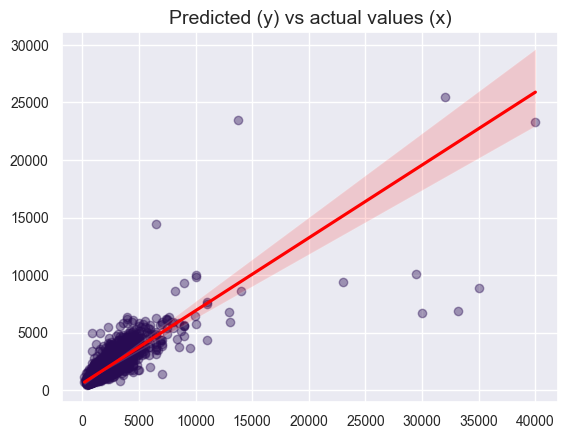

In [64]:
model_effectivness_plot = sns.regplot(
    y = final_predictions_test,
    x = Y_test,
    scatter_kws= {"alpha":0.4},
    line_kws={'color': 'red'},
)
model_effectivness_plot.set_title("Predicted (y) vs actual values (x)")
model_effectivness_plot.set_xlabel("")

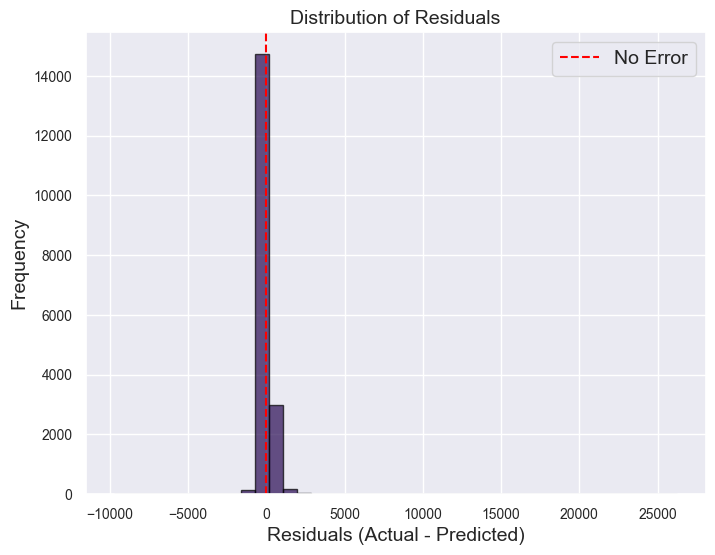

In [65]:
# Testing if errors have a normal distribution and if there are some systematic 
residuals = Y_test - final_predictions_test

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=40, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="No Error")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.legend()
plt.grid(True)
plt.show()

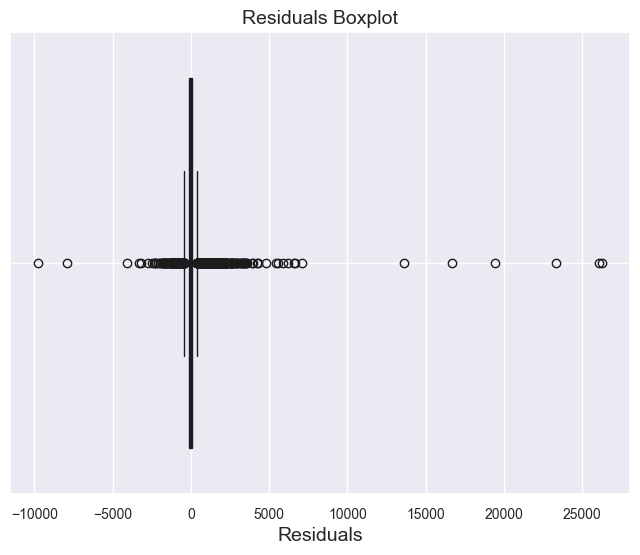

In [66]:
import seaborn as sns

# Boxplot of errors
plt.figure(figsize=(8, 6))
sns.boxplot(residuals, orient="h")
plt.title("Residuals Boxplot")
plt.xlabel("Residuals")
plt.grid(True)
plt.show()


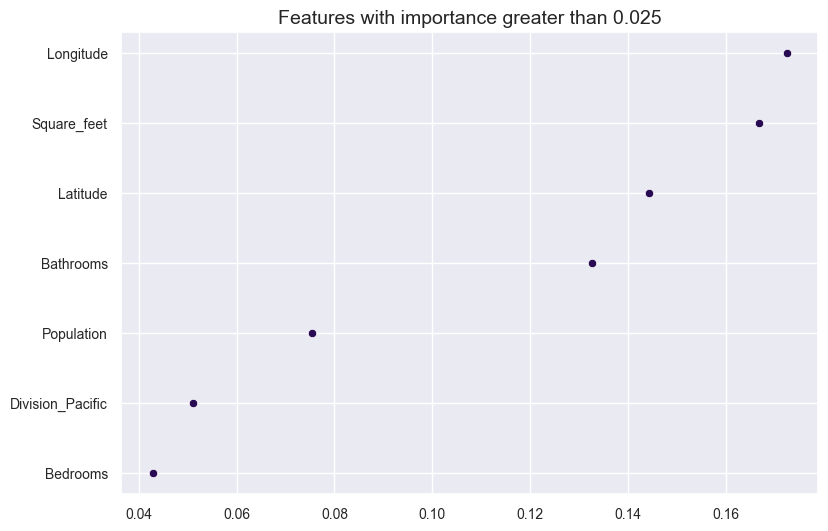

In [69]:
import pandas as pd

# Fetching features' importance
feature_importances = best_forest_model.feature_importances_
features = X_test.columns

# creating df with features
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plotting importance scores for the most import ones
plt.figure(figsize=(9, 6))
sns.scatterplot(x="Importance", y="Feature", data=importance_df[importance_df['Importance']>0.025])
plt.title("Features with importance greater than 0.025")
plt.ylabel("")
plt.xlabel("")
plt.grid(True)
plt.show()


In [68]:
if api_key is not None:
    interpretation = client.chat.completions.create(model = model,messages = [
        {"role":role,
         "content" : f" Interpret the results of the final test of the Model: random forest regressor. Results of final test on test_data: Final test RMSE: {final_test_rmse},confidence interval for RMSE: {confidence_interval},final predictions: {final_predictions_test}. Test data: {test_set_labels}"}]                                                )
    print(interpretation.choices[0].message.content)

The final test of the random forest regressor model showed a Root Mean Squared Error (RMSE) of 533.87. The confidence interval for the RMSE is [389.56, 646.74]. The model's final predictions ranged from 979.31 to 2727.70. 

Comparing the model's predictions with the actual test data, it seems that the model performed reasonably well in predicting the prices of the properties. However, it would be more insightful to further analyze the residuals and investigate any patterns or biases in the model's predictions. Additionally, further tuning of the model parameters, feature selection, or other machine learning techniques may potentially improve the model's performance.
